# Data preprocessing for Bayesian model of bike rentals

This notebook performs essential data preprocessing steps to prepare the bike rental dataset for Bayesian network modeling. It includes inspecting the distributions, making a check for possible outliers and multicolinearity, filling in missing values, categorizing continuous variables and calculating WoE (Weight of Evidence) and IV (Information Value) scores. The goal is to transform the data into a structured format suitable for training and inference with a Bayesian model predicting the number of bike rentals (not covered in this notebook).

__Source of data__:
https://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand

__Article accompanying the dataset__:
https://www.researchgate.net/publication/339088393_Using_data_mining_techniques_for_bike_sharing_demand_prediction_in_metropolitan_city

# Loading and inspecting the data

In [ ]:
import numpy as np
import pandas as pd

# Using default encoding gives UnicodeDecodeError: 'utf-8' codec can't decode byte 0xb0 in position 40: invalid start byte
# df = pd.read_csv("SeoulBikeData.csv", delimiter=",")
# Inspecting what the problematic symbol is
with open("./data/SeoulBikeData.csv", "rb") as f:
    f.seek(40)  # Move to byte 40
    problematic_byte = f.read(1)  # Read one byte
    # Decode the byte using ISO-8859-1 to display as the degree symbol
    decoded_char = problematic_byte.decode('ISO-8859-1')
    print(decoded_char)

°


In [3]:
# We repeat loading the data, this time using the appropriate encoding
df = pd.read_csv("SeoulBikeData.csv", delimiter=",", encoding="ISO-8859-1")

The data we will be working with is related to bike-sharing in Seoul. As there is a consistent rise in the number of bike users
the goal is to predict how many bikes are required for rental at each hour. The target attribute
in this case is clear: Rented Bike Count. All other attributes, albeit two (Date and Functioning Day)
are connected to weather changes, that were traced by the hour.

Let's begin our exploration of the data by checking the basic structure of the columns, if there are any missing values and if it is 
wholesome in the sense of covering the full one year date and hour range.

In [4]:
df.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [5]:
# Check for missing values
missing_values = df.isnull().sum()
missing_values

Date                         0
Rented Bike Count            0
Hour                         0
Temperature(°C)              0
Humidity(%)                  0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature(°C)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
Seasons                      0
Holiday                      0
Functioning Day              0
dtype: int64

In [6]:
# Convert 'Date' column to datetime (this keeps the time part initially)
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

# Start Date: The earliest date in the 'Date' column
start_date = df['Date'].min().date()  # Extracts only the date part (no time)

# End Date: The latest date in the 'Date' column
end_date = df['Date'].max().date()  # Extracts only the date part (no time)

# Strip the time component from 'Date' for consistent comparison
df['Date'] = df['Date'].dt.date

# Smallest Hour for Start Date: The smallest hour on the start date
start_hour = df[df['Date'] == start_date]['Hour'].min()

# Largest Hour for End Date: The largest hour on the end date
end_hour = df[df['Date'] == end_date]['Hour'].max()

hour_range = df['Hour'].unique()

print(f"Start Date: {start_date}")
print(f"End Date: {end_date}")
print(f"Smallest Hour for Start Date: {start_hour}")
print(f"Largest Hour for End Date: {end_hour}")

Start Date: 2017-12-01
End Date: 2018-11-30
Smallest Hour for Start Date: 0
Largest Hour for End Date: 23


In [7]:
# Create a reference set of all possible hours (0 to 23)
full_hour_range = set(range(24))

# Group by Date and check if each day has all 24 hours
missing_hours = []

# Iterate over each unique date
for date, group in df.groupby('Date'):
    # Get unique hours for the current date
    unique_hours = set(group['Hour'].unique())
    
    # Compare the unique hours with the full range (0-23)
    if unique_hours != full_hour_range:
        missing_hours.append(date)

if missing_hours:
    print("The following dates are missing some hours:")
    for date in missing_hours:
        print(date)
else:
    print("All dates have the full range of hours (0-23).")

All dates have the full range of hours (0-23).


## Description of the attributes

| **Attribute name**              | **Type**     | **Units / Categories / Format**               | **Description**                                                                                                                                                             |
|----------------------------------|--------------|-------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Date                             | Date         | Year - Month - Day                       | Date when the bike rental data was recorded.                                                                                                                                 |
| Rented Bike Count               | Integer      | Number of bikes         | The number of bikes rented.                                                                                                               |
| Hour                             | Integer      | Hour (0-23)             | The hour of the day (24-hour format) for which data was gathered.                                                                                                       |
| Temperature(°C)                  | Float        | °C (Celsius)            | The temperature in Celsius.                                                                                                                           |
| Humidity(%)                      | Float        | %                       | Amount of water vapor present in the air.                                                                                                         |
| Wind speed (m/s)                 | Float        | m/s (meters per second) | Indicates the rate at which wind is blowing.                                                                                                               |
| Visibility (10m)                 | Integer      | Meters                  | Visibility measured in 10-meter increments. A value of 100 means that an object can clearly be seen up to a distance of 1000 meters.                                                                                                         |
| Dew point temperature(°C)        | Float        | °C (Celsius)            | The dew point temperature. Lower values mean low moisture content - the air is cold and dry. Higher values indicate higher moisture content, making the air feel sticky.                                                                                                             |
| Solar Radiation (MJ/m²)          | Float        | MJ/m² (MegaJoules per m²)| Includes all different types of electromagnetic radiation emitted by the sun, including visible light, UV radiation, and infrared radiation. Higher values indicate more sunlight, warmth, and higher temperatures.                                                         |
| Rainfall(mm)                     | Float        | mm (millimeters)        | The height of water that would accumulate on a flat surface. 1 mm corresponds to 1 liter of water on 1 square meter of surface area. Greater than 0, up to 2 mm can be considered light rain, 2 up to 10 mm is moderate rainfall, and 10 mm or more is heavy rain.                                                                                                          |
| Snowfall (cm)                    | Float        | cm (centimeters)        | Amount of snow that has accumulated in depth.                                                                                                         |
| Seasons                          | Category     | Autumn / Spring / Summer / Winter                       | The season during which the data was recorded.                                                                                             |
| Holiday                          | Category     | Holiday / Workday                       | Indicates whether the data was recorded on a holiday or not.                                                                                              |
| Functioning Day                     | Category     | Yes / No                       | Indicates whether the rental bike system is operating on a given day.                                                                                                      |                                                                                          |


In [8]:
# Get summary statistics for numerical variables (excluding 'Hour')
df.drop(columns='Hour').describe()

,Rented Bike Count,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,704.602055,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068
std,644.997468,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746
min,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000
25%,191.000000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000
50%,504.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000
75%,1065.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000
max,3556.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000


On average, about 704 bikes were rented each hour, with the range being quite high (between 0 and 3556).

The standard deviation in temperatures indicates substantial variation in temperatures, typical for Seoul's continental climate with hot, humid summers and cold, dry winters. Similar is true for humidity and dew point temperature.

Wind speed varies less, while as expected solar radiation fluctuates more throughout the year.

The summary statistics for rainfall suggests most days had zero or minimal rainfall, with a potential for outliers with higher rainfall amounts.

Snowfall apperars to be rare, the average being low (0.08 cm) and with even the maximum recorded value not being that high (8.8 cm).

# Checking for outliers

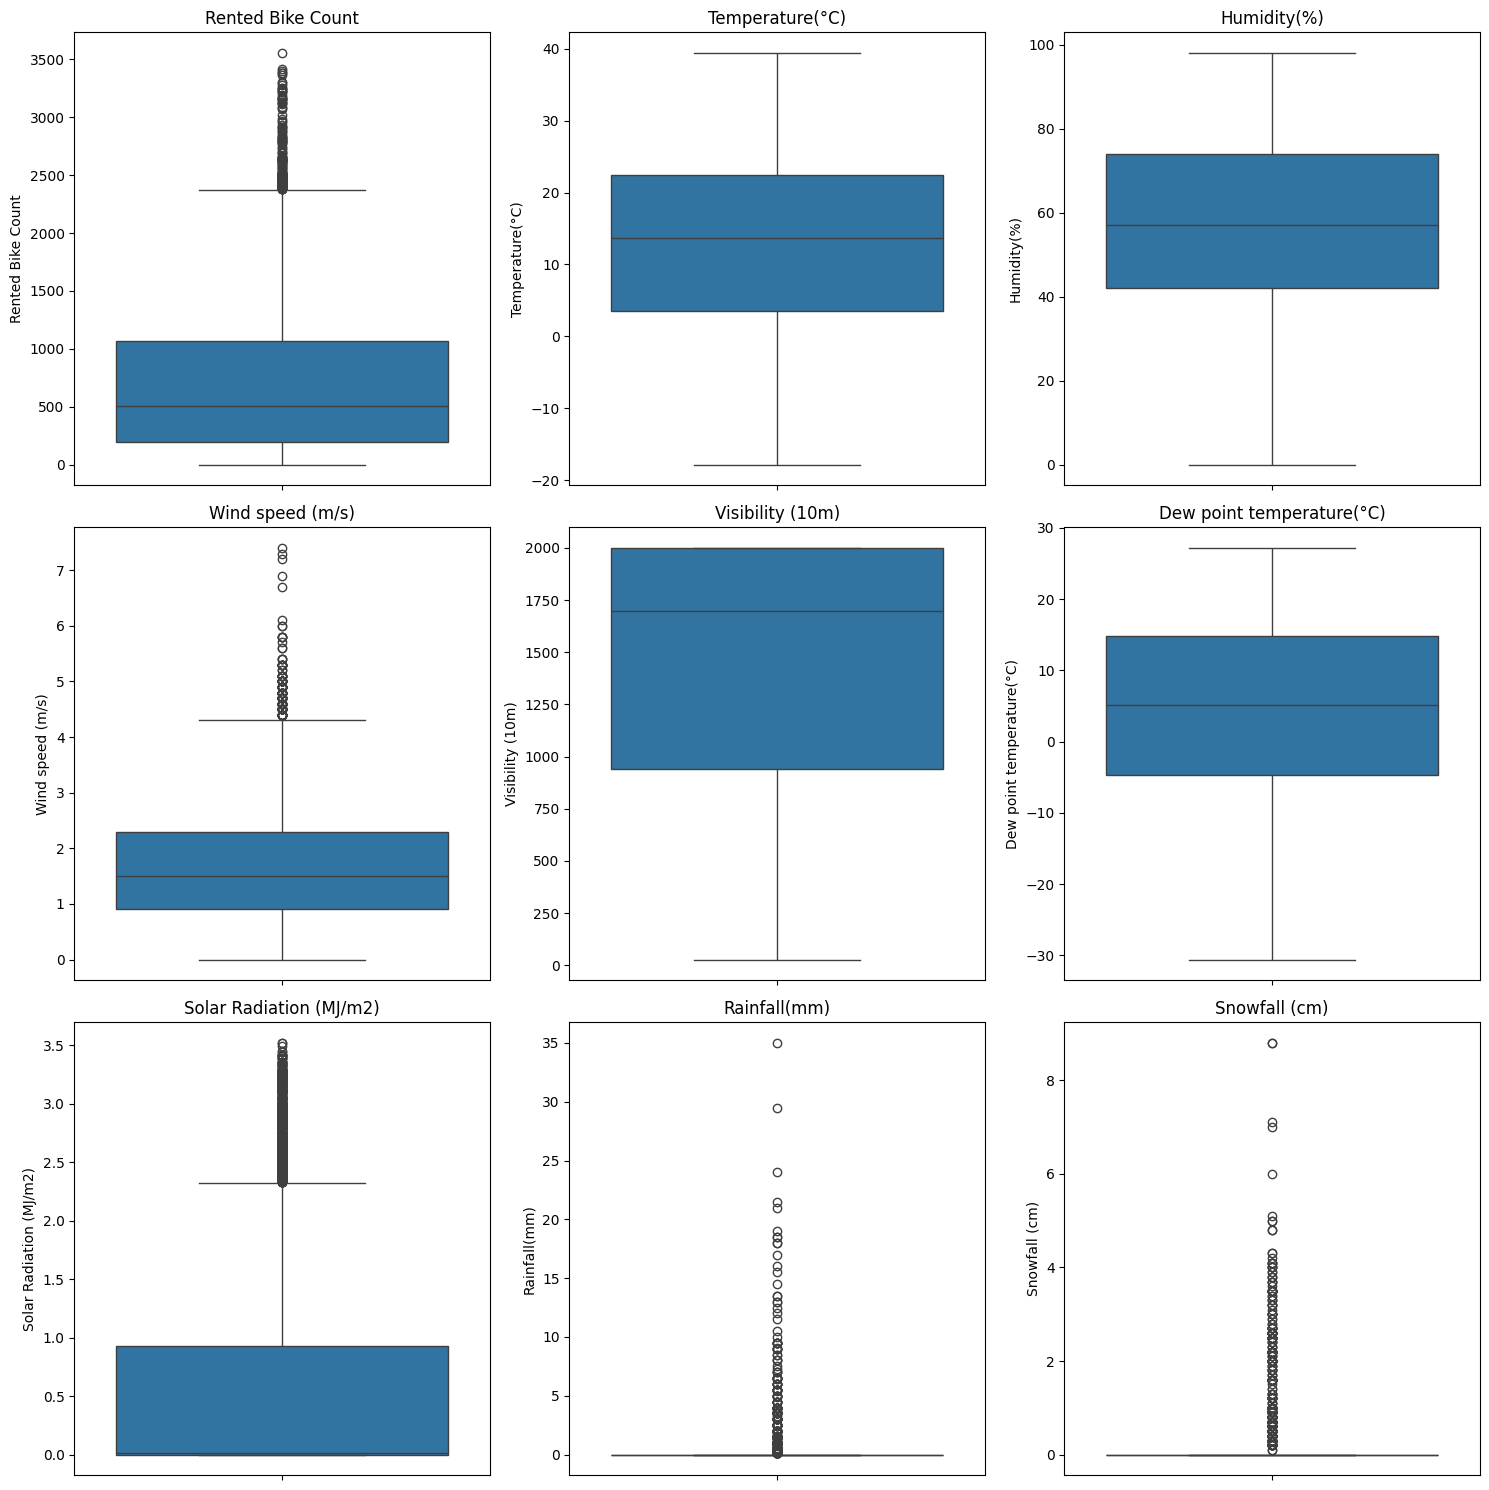

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

# Select only numeric columns and drop the 'Hour' column
numeric_df = df.select_dtypes(include=['number']).drop('Hour', axis=1)

# Loop through each numeric column and plot a boxplot
for i, col in enumerate(numeric_df.columns):
    sns.boxplot(data=df[col], ax=axes[i])
    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=45)

# Remove any unused axes
for j in range(len(numeric_df.columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


We see that all of the outliers lie on the positive side of the scale. Seaborn's boxplot function (used to display the boxplots) detects outliers based on the interquartile range (IQR) (i.e. outliers are defined as any values that lie outside the range of lower bound: 
Q1 − 1.5 × IQR or upper bound: Q3 + 1.5 × IQR). Let's confirm this by also calculating Z-score values, taking a conservative approach of the Z-score needing to be less or greater than 3 for a datapoint to count as an outlier (Z-score of 2 being the lenient alternative) and separately listing them by both ends of spectrum.

In [10]:
from scipy.stats import zscore

# Apply Z-score to the numeric columns
z_scores = numeric_df.apply(zscore)

# Identify outliers on both low and high ends
low_end_outliers = (z_scores < -3).sum()  # Count of outliers less than -3
high_end_outliers = (z_scores > 3).sum()  # Count of outliers greater than 3

print("Sum of outliers on low-end:")
print(low_end_outliers)
print()

print("Sum of outliers on high-end:")
print(high_end_outliers)

Sum of outliers on low-end:
Rented Bike Count            0
Temperature(°C)              0
Humidity(%)                  0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature(°C)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
dtype: int64

Sum of outliers on high-end:
Rented Bike Count             67
Temperature(°C)                0
Humidity(%)                    0
Wind speed (m/s)              63
Visibility (10m)               0
Dew point temperature(°C)      0
Solar Radiation (MJ/m2)       85
Rainfall(mm)                  94
Snowfall (cm)                173
dtype: int64


Let's see some concrete values to better evaluate the outliers.

In [11]:
columns_to_check = ['Rented Bike Count', 'Wind speed (m/s)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)']

top_10_highest_values = {}
for col in columns_to_check:
    top_10_highest_values[col] = df[col].nlargest(10)

for col, values in top_10_highest_values.items():
    print(f"Top 10 highest values for {col}:")
    print(values)
    print()


Top 10 highest values for Rented Bike Count:
4818    3556
4866    3418
4650    3404
4842    3384
4458    3380
4890    3365
4554    3309
6810    3298
6978    3277
6858    3256
Name: Rented Bike Count, dtype: int64

Top 10 highest values for Wind speed (m/s):
3134    7.4
3141    7.3
3138    7.2
6316    6.9
933     6.7
3140    6.1
1309    6.0
2174    6.0
87      5.8
1724    5.8
Name: Wind speed (m/s), dtype: float64

Top 10 highest values for Solar Radiation (MJ/m2):
4069    3.52
4165    3.52
4117    3.49
6205    3.45
4164    3.44
4068    3.42
4405    3.42
4717    3.42
4861    3.42
4166    3.41
Name: Solar Radiation (MJ/m2), dtype: float64

Top 10 highest values for Rainfall(mm):
3997    35.0
6501    29.5
5132    24.0
5034    21.5
6524    21.0
4012    19.0
5099    18.5
6498    18.5
8229    18.0
8232    18.0
Name: Rainfall(mm), dtype: float64

Top 10 highest values for Snowfall (cm):
8602    8.8
8603    8.8
8601    7.1
8604    7.0
8605    6.0
420     5.1
421     5.0
8606    5.0
418     4.8

We see that we can keep all the values, since none of them qualify as *true* outliers:

- All of the displayed values for Rented Bike Count are plausible and close to each other, with no apparent extreme outlier.

- None of the values of wind speed seem excessively extreme, given that wind speeds can go above 10 m/s during heavy storms.

- Values for solar radiation are tightly clustered and again typical of the attribute in question.

- Rainfall contains most variance but all of them are possible in more extreme weather conditions, which in Seoul are not uncommon during the monsoon season.

- Values for snowfall all lie inside a reasonable range.

Let's take look at how the distributions for the numeric values and two of the categorical ones look.

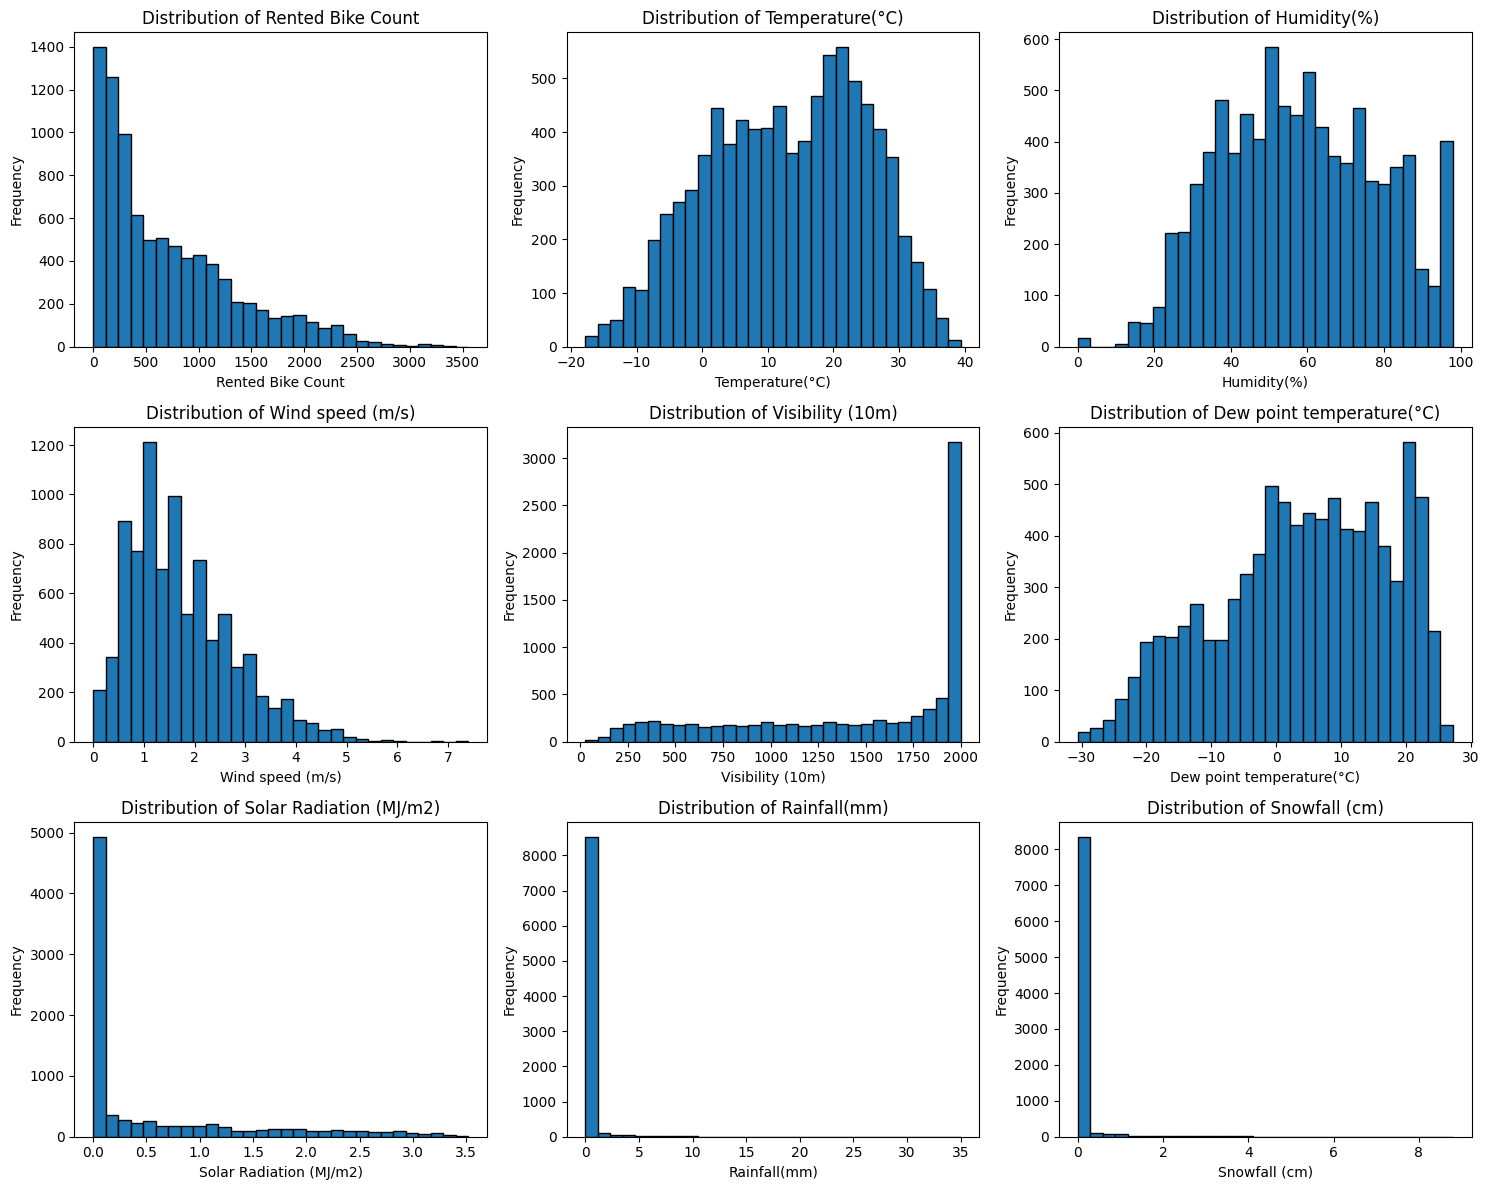

In [12]:
# Plot histograms for each numerical column (excluding 'Hour')
numerical_columns = df.select_dtypes(include='number').columns
numerical_columns = numerical_columns[numerical_columns != 'Hour']  # Exclude 'Hour' from numerical columns

num_columns = 3
num_rows = (len(numerical_columns) // num_columns) + (len(numerical_columns) % num_columns > 0)

fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 12))

axes = axes.flatten()

for i, col in enumerate(numerical_columns):
    axes[i].hist(df[col], bins=30, edgecolor='black')
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Distributions of temperature, humidity and dew point temperature are roughly bell-shaped, indicating a normal distribution. The higher bin count exposes a couple of peaks though, making it more apropriate to call the distributions bi-modal (in the case of temperature) or multimodal (in the case of humidity and dew point temperature). Temperature tends to hover around a central point (mean is 12.89), with fewer extreme (i.e. very high or low) temperatures. The humidity and dew point temperature distributions differ in this regard with having more extreme peaks, especially on the right end of the spectrum. This indicates more days with moist air conditions or being humid.

Distributions of rented bike count, solar radiation, rainfall and snowfall all follow a right-skewed pattern. For rented bike count this tells us that the majority of data instances represent low rented bike counts and fewer instances represent higher rented bike counts. As for the other three distributions this kind of pattern is present even more, with most values concentrated around 0 (for solar radiation this can partially be attributed to night of day, while possibly also meaning many cloudy days; it is surprising not to see more frequent rainfall, since Seoul experiences monsoons in the summer, while snowfall is expectedly low for this region).

Wind speed follows a similar story with most speeds being on the lower end of the spectrum. As expected, high wind speeds are less frequent, which is typical for natural conditions in most parts of the world.

Visibility seems to be often clear as indicated by the sharp peak at the 2000 mark, which seems to be the default highest value.

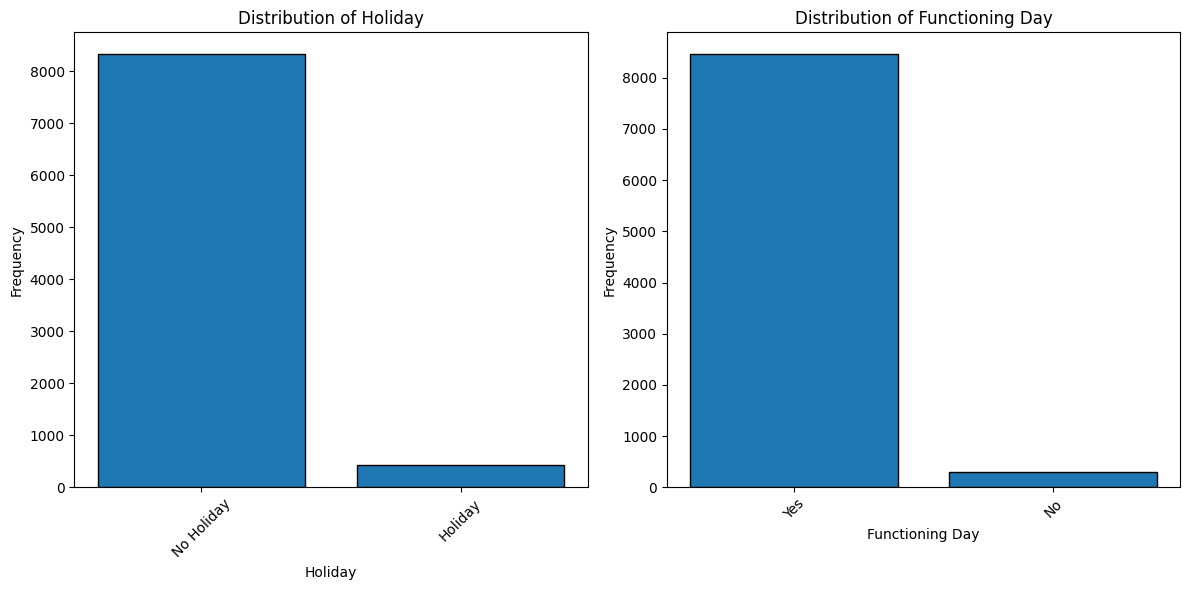

In [13]:
categorical_columns = ['Holiday', 'Functioning Day']

num_columns = len(categorical_columns)
num_rows = 1

fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, 6))

for i, col in enumerate(categorical_columns):
    axes[i].bar(df[col].value_counts().index, df[col].value_counts().values, edgecolor='black')
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

We are not showing the distributions for Date, Season, Hour, because they are uniform. As for the remaining two categorical values of Holiday and Functioning Day the results are again nothing unexpected - there are much less data points recorded on holidays than outside holidays and the bike rental service was functional in great majority of time. 

Before we continue, let's focus back on the distribution of Rented Bike Counts. We notice that the attribute seems to hold a large amount of zero values. Let's get an exact number.

In [14]:
count_zero_bike_entries = df[df['Rented Bike Count'] == 0].shape[0]

print(f"Number of entries where Rented Bike Count is 0: {count_zero_bike_entries}")

Number of entries where Rented Bike Count is 0: 295


From the article that accompanies the data we read that data was gathered for entire Seoul region. Knowing that Seoul boasts of more than a 9 million population one would not be safe to bet on zero bike rentals, regardless of the hour, so how come we have not one, but 295 instances in our data where this seems to be true? 

Looking at the other attributes we ask ourselves if Functioning Day may lead us to the right answer - we expect the rented bike count to be 0 when the bike rental service (i.e. Seoul Bike Ddareungi) was not functioning, so let's see if this is truly the case. 

In [15]:
distinct_values = df['Functioning Day'].unique()
print(f"Distinct values of 'Functioning Day': {', '.join(map(str, distinct_values))}")
print()

sums = df.groupby('Functioning Day')['Rented Bike Count'].sum()
print(f"Sum of rentals by \n{sums}")
print()

filter_condition = (df['Functioning Day'] == 'Yes') & (df['Rented Bike Count'] == 0)

entries_with_zero_bikes = df[filter_condition]

if not entries_with_zero_bikes.empty:
    print("Entries where Functioning Day is 'Yes' but Rented Bike Count is 0:")
    print(entries_with_zero_bikes)
else:
    print("No entries where Functioning Day is 'Yes' but Rented Bike Count is 0.")

Distinct values of 'Functioning Day': Yes, No

Sum of rentals by 
Functioning Day
No           0
Yes    6172314
Name: Rented Bike Count, dtype: int64

No entries where Functioning Day is 'Yes' but Rented Bike Count is 0.


Confirming our assumption this brings us to a dilemma of what to do with the zero entries. If we keep them we skew the data, none of the attributes holding much value when nr. of bikes rented is 0, but getting rid of them means we introduce gaps in our time-ordered dataset.

One way to resolve this is to interpolate the missing values and that is just what we'll do.

First we want to gain a better understanding of what is the scope of data we will
be changing.

In [16]:
unique_zero_dates = df[df['Rented Bike Count'] == 0]['Date'].nunique()
print(f"Nr. of unique dates, that contain a zero rented bike count entry: {unique_zero_dates}")

zero_rental_dates = df[df['Rented Bike Count'] == 0]['Date'].unique()

for date in zero_rental_dates:
    entries_for_date = df[df['Date'] == date]
    if (entries_for_date['Rented Bike Count'] > 0).any():
        print(f"For the date {date}, there are entries with non-zero rented bike counts.")
    else:
        print(f"For the date {date}, all entries have zero rented bike counts.")

Nr. of unique dates, that contain a zero rented bike count entry: 13
For the date 2018-04-11, all entries have zero rented bike counts.
For the date 2018-05-10, all entries have zero rented bike counts.
For the date 2018-09-18, all entries have zero rented bike counts.
For the date 2018-09-19, all entries have zero rented bike counts.
For the date 2018-09-28, all entries have zero rented bike counts.
For the date 2018-09-30, all entries have zero rented bike counts.
For the date 2018-10-02, all entries have zero rented bike counts.
For the date 2018-10-04, all entries have zero rented bike counts.
For the date 2018-10-06, there are entries with non-zero rented bike counts.
For the date 2018-10-09, all entries have zero rented bike counts.
For the date 2018-11-03, all entries have zero rented bike counts.
For the date 2018-11-06, all entries have zero rented bike counts.
For the date 2018-11-09, all entries have zero rented bike counts.


Then we proceed with interpolating the values.

In [17]:
# Identify zeros → mask
rb = df['Rented Bike Count']
zero_mask = (rb == 0)

# Compute “previous non-zero” and “next non-zero” series
# by first turning zeros into NaN
rb_nan = rb.replace(0, np.nan)

prev_nonzero = rb_nan.ffill()   # pandas.Series.ffill: propagate last valid forward  
next_nonzero = rb_nan.bfill()   # pandas.Series.bfill: propagate next valid backward  

# Build the interpolated value as the midpoint
interp_value = (prev_nonzero + next_nonzero) / 2

Before we merge the changes on to the original dataframe we want to inspect them.

In [18]:
inspect = pd.DataFrame({
    'Date':         df['Date'],
    'Hour':         df['Hour'],
    'original':     rb_nan,
    'prev_anchor':  prev_nonzero,
    'next_anchor':  next_nonzero,
    'interp':       interp_value
})

# Grab only the rows that were zero → NaN and thus got an interp
to_check = inspect[inspect['original'].isna()]

# Set the option to display more rows
pd.set_option('display.max_rows', None)

print(to_check)

            Date  Hour  original  prev_anchor  next_anchor  interp
3144  2018-04-11     0       NaN        212.0        504.0   358.0
3145  2018-04-11     1       NaN        212.0        504.0   358.0
3146  2018-04-11     2       NaN        212.0        504.0   358.0
3147  2018-04-11     3       NaN        212.0        504.0   358.0
3148  2018-04-11     4       NaN        212.0        504.0   358.0
3149  2018-04-11     5       NaN        212.0        504.0   358.0
3150  2018-04-11     6       NaN        212.0        504.0   358.0
3151  2018-04-11     7       NaN        212.0        504.0   358.0
3152  2018-04-11     8       NaN        212.0        504.0   358.0
3153  2018-04-11     9       NaN        212.0        504.0   358.0
3154  2018-04-11    10       NaN        212.0        504.0   358.0
3155  2018-04-11    11       NaN        212.0        504.0   358.0
3156  2018-04-11    12       NaN        212.0        504.0   358.0
3157  2018-04-11    13       NaN        212.0        504.0   3

The results look OK so we proceed with overwriting the zeros in the original dataframe.

In [19]:
df['Rented Bike Count'] = rb.where(~zero_mask, interp_value)

We check if overwrite was succesfull.

In [20]:
count_zero_bike_entries = df[df['Rented Bike Count'] == 0].shape[0]

print(f"Number of entries where Rented Bike Count is 0: {count_zero_bike_entries}")

Number of entries where Rented Bike Count is 0: 0


We see that it was, but note that this is far from being a perfect solution, since all of the interpolated values for a given series of zeros are the same. A possibly better solution would be making the ffill() and bfill() functions be aware of the 'Hour' for each datapoint, which would welcomely dissolve the uniformity of the interpolated values. We leave this approach asside though for future exercise, as our current solution was simpler to implement and still provides gains relative to the situation we had at the start.

Since it doesn't carry any useful information for us anymore we decide to get rid of 'Functioning Day' attribute.

In [21]:
df = df.drop(columns=['Functioning Day'])

# Verify the column is removed
print(df.head())

         Date  Rented Bike Count  Hour  Temperature(°C)  Humidity(%)  \
0  2017-12-01              254.0     0             -5.2           37   
1  2017-12-01              204.0     1             -5.5           38   
2  2017-12-01              173.0     2             -6.0           39   
3  2017-12-01              107.0     3             -6.2           40   
4  2017-12-01               78.0     4             -6.0           36   

   Wind speed (m/s)  Visibility (10m)  Dew point temperature(°C)  \
0               2.2              2000                      -17.6   
1               0.8              2000                      -17.6   
2               1.0              2000                      -17.7   
3               0.9              2000                      -17.6   
4               2.3              2000                      -18.6   

   Solar Radiation (MJ/m2)  Rainfall(mm)  Snowfall (cm) Seasons     Holiday  
0                      0.0           0.0            0.0  Winter  No Holiday  
1 

Following the contents of the article accompanying the dataset we also decide to add an additional attribute, Day of week, which is imputed from dates.

In [22]:
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df['Day of week'] = df['Date'].dt.day_name()

# Verify the new column
print(df[['Date', 'Day of week']].head())

        Date Day of week
0 2017-12-01      Friday
1 2017-12-01      Friday
2 2017-12-01      Friday
3 2017-12-01      Friday
4 2017-12-01      Friday


## Calculating Weight of Evidence (WoE) and Information Value (IV)

At this point we need to introduce additional transformations to the data. To make our job of calculating WoE and IV easier we first divide the Rented Bike Count into two classes, representing 'High' and 'Low' values. To to this we'll use K-means clustering.

        Date  Hour  Rented Bike Count  Cluster
0 2017-12-01     0              254.0        1
1 2017-12-01     1              204.0        1
2 2017-12-01     2              173.0        1
3 2017-12-01     3              107.0        1
4 2017-12-01     4               78.0        1


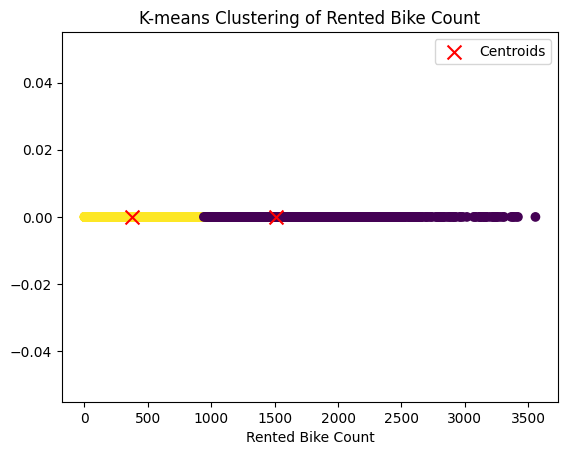

In [23]:
from sklearn.cluster import KMeans

# Using 'Rented Bike Count' column for clustering
rented_bike_counts = df['Rented Bike Count'].values.reshape(-1, 1)

# Apply K-means with k=2 (2 clusters for High and Low)
kmeans = KMeans(n_clusters=2, random_state=0).fit(rented_bike_counts)

# Get the cluster labels and centroids
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Create a column with the results
df['Cluster'] = labels

print(df[['Date', 'Hour', 'Rented Bike Count', 'Cluster']].head())

plt.scatter(df['Rented Bike Count'], [0]*len(df), c=labels, cmap='viridis')
plt.scatter(centroids[:, 0], [0]*len(centroids), c='red', marker='x', s=100, label='Centroids')
plt.xlabel('Rented Bike Count')
plt.title('K-means Clustering of Rented Bike Count')
plt.legend()
plt.show()


Let's print basic statistics to gain a better feeling of how the data is divided.

          count         mean         std    min     25%     50%      75%  \
Cluster                                                                    
0        2782.0  1505.076923  490.977754  942.0  1101.0  1356.0  1835.75   
1        5978.0   373.841000  264.857442    2.0   157.0   305.0   586.00   

            max  
Cluster          
0        3556.0  
1         941.0  


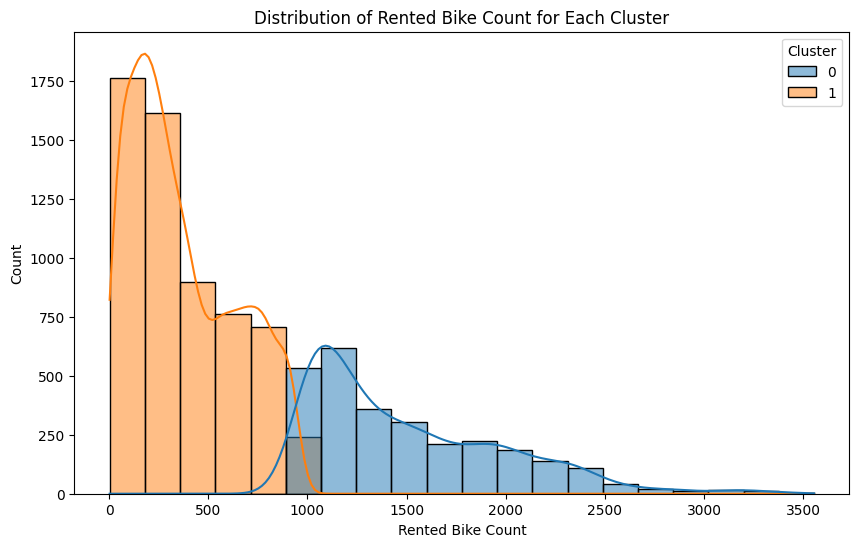

In [24]:
cluster_stats = df.groupby('Cluster')['Rented Bike Count'].describe()

print(cluster_stats)

# Plot histogram of the rented bike counts for each cluster ('High' and 'Low')
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Rented Bike Count', hue='Cluster', kde=True, bins=20)
plt.title('Distribution of Rented Bike Count for Each Cluster')
plt.show()

We are happy with the results, but it would be nice to have clearer labels. We'll remap the ones of the cluster and replace the numerical counts of 'Rented Bike Count' with them. Along the way we'll also get rid of the parentheses along with its contents in the names of all the columns, so they won't distract us in further steps.

In [25]:
# Rename clusters: 0 -> 'High', 1 -> 'Low'
df['Cluster'] = df['Cluster'].map({0: 'high', 1: 'low'})

# Replace 'Rented Bike Count' column with the 'Cluster' column values
df['Rented Bike Count'] = df['Cluster']

# Drop the old 'Cluster' column, as it's no longer needed
df.drop(columns=['Cluster'], inplace=True)

# Print the updated DataFrame to verify
print(df[['Date', 'Hour', 'Rented Bike Count']].head())

        Date  Hour Rented Bike Count
0 2017-12-01     0               low
1 2017-12-01     1               low
2 2017-12-01     2               low
3 2017-12-01     3               low
4 2017-12-01     4               low


In [26]:
# Regex pattern that matches any text inside parentheses (including the parentheses themselves) and removes it
df.columns = df.columns.str.replace(r'\s*\(.*\)', '', regex=True).str.strip()
df.columns

Index(['Date', 'Rented Bike Count', 'Hour', 'Temperature', 'Humidity',
       'Wind speed', 'Visibility', 'Dew point temperature', 'Solar Radiation',
       'Rainfall', 'Snowfall', 'Seasons', 'Holiday', 'Day of week'],
      dtype='object')

Rented Bike Count
high    2782
low     5978
Name: Rented Bike Count, dtype: int64


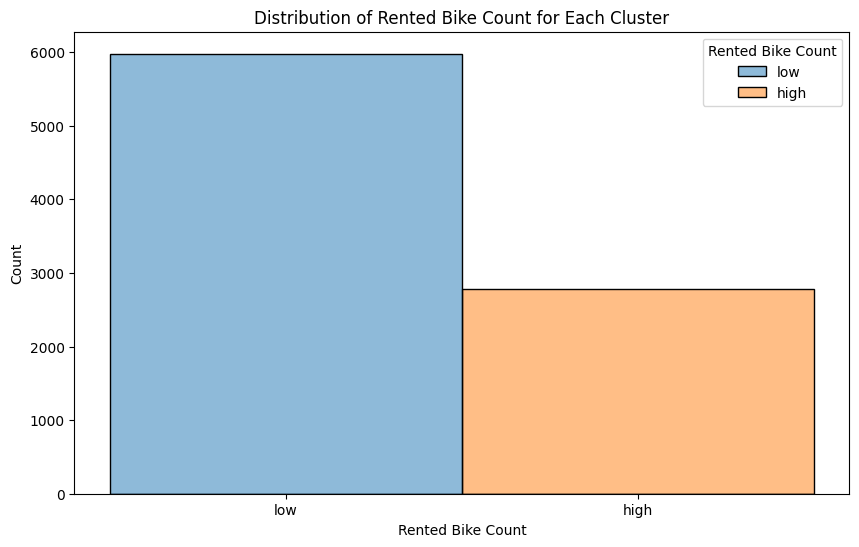

In [27]:
# The counts for each cluster ('High' and 'Low')
cluster_stats = df.groupby('Rented Bike Count')['Rented Bike Count'].count()

print(cluster_stats)

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Rented Bike Count', hue='Rented Bike Count', kde=True, bins=20)
plt.title('Distribution of Rented Bike Count for Each Cluster')
plt.show()

Here we have an even clearer view that the class representing lower counts of rented bikes is bigger, which is what was to be expected. What remains before starting the WoE and IV calculations is to discretisize the other continous variables we have in our dataset.

To divide the specific datapoints into classes we can use simple heuristics, like the one we provided at the beginning of the notebook for 'Rainfall' (see section with description of attributes; emphasis added to the words that will be used as labels): "Greater than 0, up to 2 mm can be considered `light` rain, 2 up to 10 mm is `moderate` rainfall, and 10 mm or more is `heavy` rain". We'll also add `no` as the fourth label, indicating rain not being present.

Same can be done regarding the other numerical attributes* (taking also into account how they affect cycling):

'Wind speed' ranges: 
- `light` (0 to 4 m/s), not challenging for cycling, doesn't create much resistance;
- `strong` (4 m/s and above), can cause noticeable resistance, making cycling more challenging;

'Humidity':
- `low` (0 to 40%) the air feels drey and comfortable, sweat is easy evaporated;
- `moderate` (40 to 70%): Air is moderately moist, sweat evaporation slows down;
- `high` (70 to 100%): Air feels damp, sweat doesn't evaporate effectively.

'Temperature':
- `cold` (anything up to 10°C): low temperatures, uncomfortable for cycling;
- `moderate` (10 to 25°C): ideal temperature;
- `hot` (25°C and above): cycling and similar physical activities become challenging.

'Dew Point Temperature':
- `low` (anything up to 5°C): air is dry, no excess moisture in the air, cycling is comfortable;
- `moderate` (5 to 15°C): slightly uncomfortable feeling as sweat evaporates more slowly;
- `high` (15°C and above): muggy, uncomfortable cycling conditions;

'Solar Radiation':
- `low` (0 to 2MJ/m²): ideal conditions, almost no discomfort from heat;
- `high` (2 MJ/m² and above): noticeable discomfort, especially if cycling for long durarions.

'Snowfall':
It makes much more difference (at least in this case) if snow is being present at all, then the degree to which
it is present (i.e., the variation and maximum value of the attribute are small), so we introduce only two classes: `yes` and `no`, designating if snowfall is present or not.

*'Hours' is also numerical, but the numbers can be interpreted as representing separate categories.

The one attribute we didn't mention above and that isn't categorical (or date) is 'Visibility'. This one is a little trickier to determine because the report doesn't declare which convention they followed specifying the values. The most common value for this attribute is 2000, which should represent visibility of 20 km (2000 × 10m). We didn't manage to find any references that would confirm our interpretation though, but only some that don't - for example, in weather forecasts designed for needs of aviation (Terminal Aerodrome Forecast or TAF) visibility of 10 km or more is denoted as 9999. To resolve this situation we'll again resort to using K-means clustering, this time with k of 3, for dividing 'Visibility' values into 3 classes of `low`, `moderate` and `high`.

        Date  Hour  Visibility  Cluster
0 2017-12-01     0        2000        1
1 2017-12-01     1        2000        1
2 2017-12-01     2        2000        1
3 2017-12-01     3        2000        1
4 2017-12-01     4        2000        1


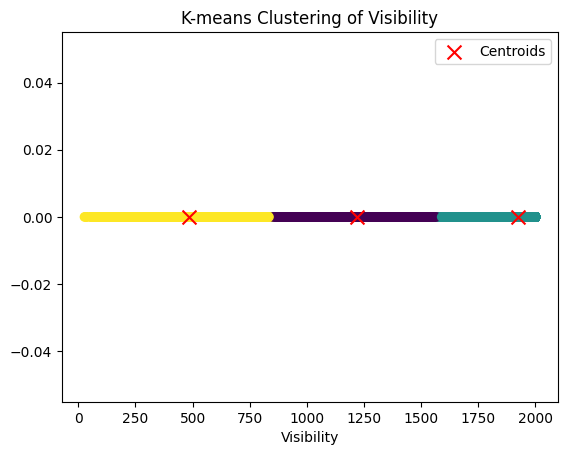

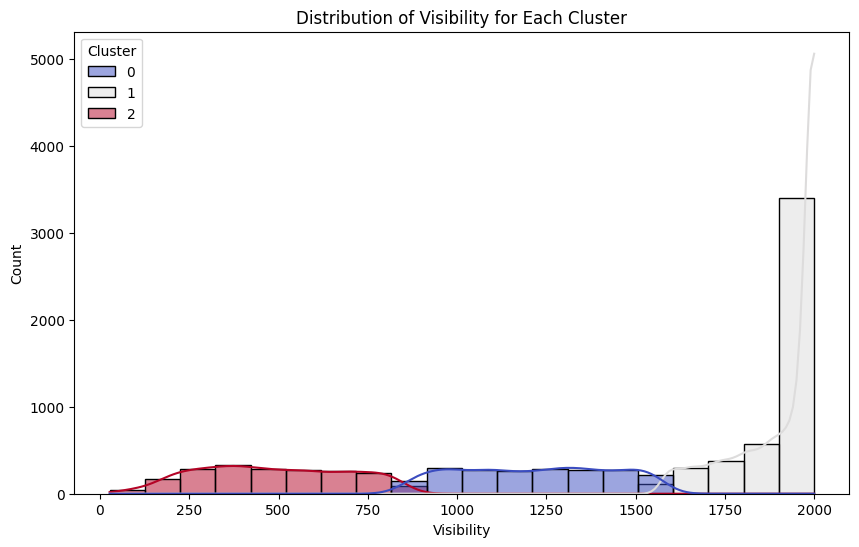

          count         mean         std     min      25%     50%     75%  \
Cluster                                                                     
0        2024.0  1220.367095  208.451837   852.0  1040.00  1225.5  1398.0   
1        4764.0  1922.868598  115.773403  1573.0  1876.75  1994.0  2000.0   
2        1972.0   484.799696  203.627833    27.0   320.00   473.0   660.0   

            max  
Cluster          
0        1570.0  
1        2000.0  
2         851.0  

Updated dataframe:
        Date  Hour Visibility
0 2017-12-01     0       high
1 2017-12-01     1       high
2 2017-12-01     2       high
3 2017-12-01     3       high
4 2017-12-01     4       high


In [28]:
# Using the 'Visibility' column for clustering
visibility_data = df['Visibility'].values.reshape(-1, 1)

# Apply K-means with k=3 (3 clusters for Low, Moderate, and High Visibility)
kmeans = KMeans(n_clusters=3, random_state=0).fit(visibility_data)

# Get the cluster labels and centroids
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Create a column with the results
df['Cluster'] = labels

print(df[['Date', 'Hour', 'Visibility', 'Cluster']].head())

# Plotting the clusters
plt.scatter(df['Visibility'], [0]*len(df), c=labels, cmap='viridis')
plt.scatter(centroids[:, 0], [0]*len(centroids), c='red', marker='x', s=100, label='Centroids')
plt.xlabel('Visibility')
plt.title('K-means Clustering of Visibility')
plt.legend()
plt.show()

# Plot the distribution of Visibility colored by clusters
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Visibility', hue='Cluster', kde=True, bins=20, palette='coolwarm')
plt.title('Distribution of Visibility for Each Cluster')
plt.show()

# Basic statistics for each cluster
cluster_stats = df.groupby('Cluster')['Visibility'].describe()

print(cluster_stats)

# Map clusters to appropriate labels
df['Visibility'] = df['Cluster'].map({0: 'moderate', 1: 'high', 2: 'low'})

# Drop the old 'Cluster' column, as it's no longer needed
df.drop(columns=['Cluster'], inplace=True)

print("\nUpdated dataframe:")
print(df[['Date', 'Hour', 'Visibility']].head())

With 'Visibility' resolved let's apply the steps to discretisize the other attributes we mentioned above.

In [29]:
# Convert a numerical column to categorical based on the provided heuristics
def convert_to_categorical(df):
    # Rainfall
    def categorize_rainfall(rain):
        if rain == 0:
            return 'no'
        elif 0 < rain < 2:
            return 'light'
        elif 2 <= rain < 10:
            return 'moderate'
        elif rain >= 10:
            return 'heavy'
        else:
            return 'no'

    # Wind speed
    def categorize_wind_speed(speed):
        if 0 <= speed < 4:
            return 'light'
        elif speed >= 4:
            return 'strong'

    # Humidity
    def categorize_humidity(humidity):
        if 0 <= humidity < 40:
            return 'low'
        elif 40 <= humidity < 70:
            return 'moderate'
        elif 70 <= humidity <= 100:
            return 'high'

    # Temperature
    def categorize_temperature(temp):
        if temp < 10:
            return 'cold'
        elif 10 <= temp < 25:
            return 'moderate'
        elif temp >= 25:
            return 'hot'

    # Dew point temperature
    def categorize_dew_point(dew_point):
        if dew_point < 5:
            return 'low'
        elif 5 <= dew_point < 15:
            return 'moderate'
        elif dew_point >= 15:
            return 'high'

    # Solar radiation
    def categorize_solar_radiation(radiation):
        if 0 <= radiation < 2:
            return 'low'
        elif radiation >= 2:
            return 'high'
        
    # Snowfall
    def categorize_snowfall(snow):
        if snow > 0:
            return 'yes'
        else:
            return 'no'

    # Apply the categorization functions to the appropriate columns
    df['Rainfall'] = df['Rainfall'].apply(categorize_rainfall)
    df['Wind speed'] = df['Wind speed'].apply(categorize_wind_speed)
    df['Humidity'] = df['Humidity'].apply(categorize_humidity)
    df['Temperature'] = df['Temperature'].apply(categorize_temperature)
    df['Dew point temperature'] = df['Dew point temperature'].apply(categorize_dew_point)
    df['Solar Radiation'] = df['Solar Radiation'].apply(categorize_solar_radiation)
    df['Snowfall'] = df['Snowfall'].apply(categorize_snowfall)

    # For 'Hour', treat it as a categorical variable (no need to apply ranges)
    # Convert all columns to categorical except 'Date'
    categorical_columns = [col for col in df.columns if col != 'Date']
    
    for column in categorical_columns:
        df[column] = df[column].astype('category')

    # Print the updated DataFrame to verify
    print(df.head())

    return df

df = convert_to_categorical(df)

        Date Rented Bike Count Hour Temperature  Humidity Wind speed  \
0 2017-12-01               low    0        cold       low      light   
1 2017-12-01               low    1        cold       low      light   
2 2017-12-01               low    2        cold       low      light   
3 2017-12-01               low    3        cold  moderate      light   
4 2017-12-01               low    4        cold       low      light   

  Visibility Dew point temperature Solar Radiation Rainfall Snowfall Seasons  \
0       high                   low             low       no       no  Winter   
1       high                   low             low       no       no  Winter   
2       high                   low             low       no       no  Winter   
3       high                   low             low       no       no  Winter   
4       high                   low             low       no       no  Winter   

      Holiday Day of week  
0  No Holiday      Friday  
1  No Holiday      Friday  
2 

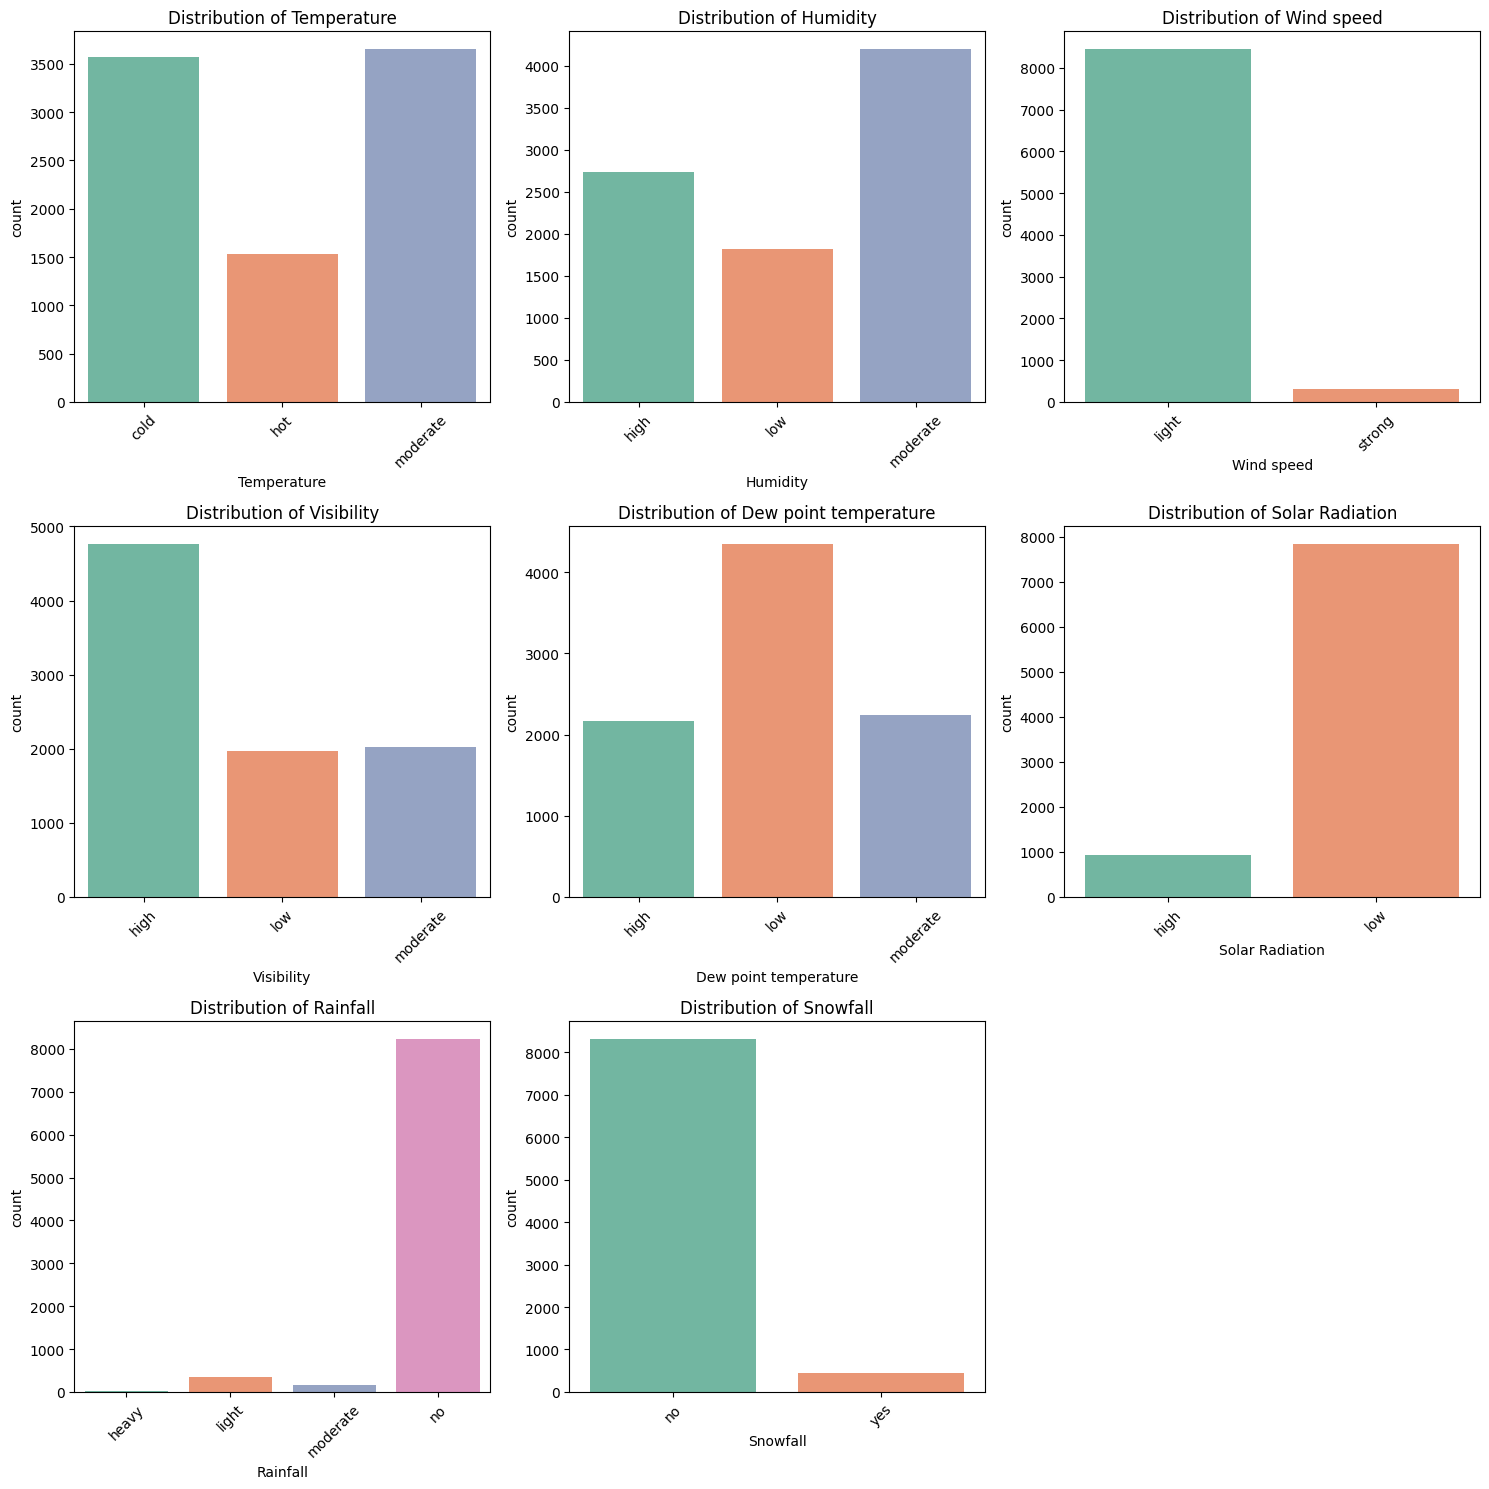

In [30]:
# Along with 'Rented Bike Count' we allready inspected before, we exclude 'Hour', 'Seasons', 'Holiday', 'Day of week' from categorical_columns, as their
# distribution is inherently uniform
exclude_columns = ['Rented Bike Count', 'Hour', 'Seasons', 'Holiday', 'Day of week']
categorical_columns = [col for col in df.columns if col not in exclude_columns and df[col].dtype == 'category']

# Plotting each categorical column's distribution
num_columns = len(categorical_columns)
ncols = 3 
nrows = int(np.ceil(num_columns / ncols))

plt.figure(figsize=(15, 5 * nrows))

for i, column in enumerate(categorical_columns, 1):
    plt.subplot(nrows, ncols, i)
    sns.countplot(data=df, x=column, hue=column, palette='Set2', legend=False)
    plt.title(f'Distribution of {column}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

By checking the distributions we ensure the heuristics we applied were appropiate.

Before we proceed we need to clear another obstacle that could prove crucial for improving our Bayesian network model we are preparing the data for. If we go through the list of all attributes we notice some of them are possibly highly correlated, notably these: 'Temperature', 'Dew point temperature', 'Solar Radiation', 'Seasons'. If true, this might indicate too much of redundant information being present in our data, leading to overfitting, increased model complexity and skewed IV scores. If we would deal with this problem at the beginning of our data exploration and cleaning steps we could've used the Variance Inflation Factor (VIF) to inspect which of the attributes are indicative of the problem we are describing (i.e., multicolinearity). Since at this stage we are dealing with categorical data, we have a possible alternative in using a combination of Cramér's V measure (shows how strongly two categorical attributes are corelated) and Chi-Squared test (to test the independence or statistical significance of any categorical attributes that show high corelation).

In [31]:
from scipy.stats import chi2_contingency

# Function to calculate Cramér's V
def cramers_v(x, y):
    # Create a contingency table
    contingency_table = pd.crosstab(x, y)
    
    # Perform the Chi-squared test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    # Calculate Cramér's V
    n = contingency_table.sum().sum()  # total observations
    v = np.sqrt(chi2 / (n * min(contingency_table.shape) - 1))
    
    return v

# List of categorical columns to check for collinearity
categorical_columns = [
    'Hour', 'Temperature', 'Humidity', 'Wind speed', 'Visibility', 
    'Dew point temperature', 'Solar Radiation', 'Rainfall', 
    'Snowfall', 'Seasons', 'Holiday', 'Day of week'
]

# Create a matrix to store the Cramér's V values
cramers_v_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns)

# Calculate Cramér's V for each pair of categorical columns (0 indicates no association between two variables,
# 1 indicates a perfect association between two variables)
for col1 in categorical_columns:
    for col2 in categorical_columns:
        if col1 != col2:  # Avoid calculating for the same variable with itself
            cramers_v_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])
        else:
            cramers_v_matrix.loc[col1, col2] = 1  # Cramér's V for a variable with itself is 1

print(cramers_v_matrix)

                           Hour Temperature  Humidity Wind speed Visibility  \
Hour                          1    0.122549  0.274161   0.124112   0.083395   
Temperature            0.122549           1  0.117623   0.052742   0.102026   
Humidity               0.274161    0.117623         1   0.096212   0.285838   
Wind speed             0.124112    0.052742  0.096212          1   0.047512   
Visibility             0.083395    0.102026  0.285838   0.047512          1   
Dew point temperature  0.016939    0.513669  0.238095   0.068855   0.042578   
Solar Radiation        0.399892    0.196217  0.207152   0.056063   0.078343   
Rainfall                0.05778    0.086594  0.202868   0.018958   0.148805   
Snowfall               0.031876    0.196541  0.060734   0.046199   0.060082   
Seasons                     0.0    0.531706  0.158323   0.082853   0.118899   
Holiday                     0.0     0.04445  0.038156   0.017075   0.043163   
Day of week                 0.0     0.02604  0.04376

Let's make the matrix easier to inspect.

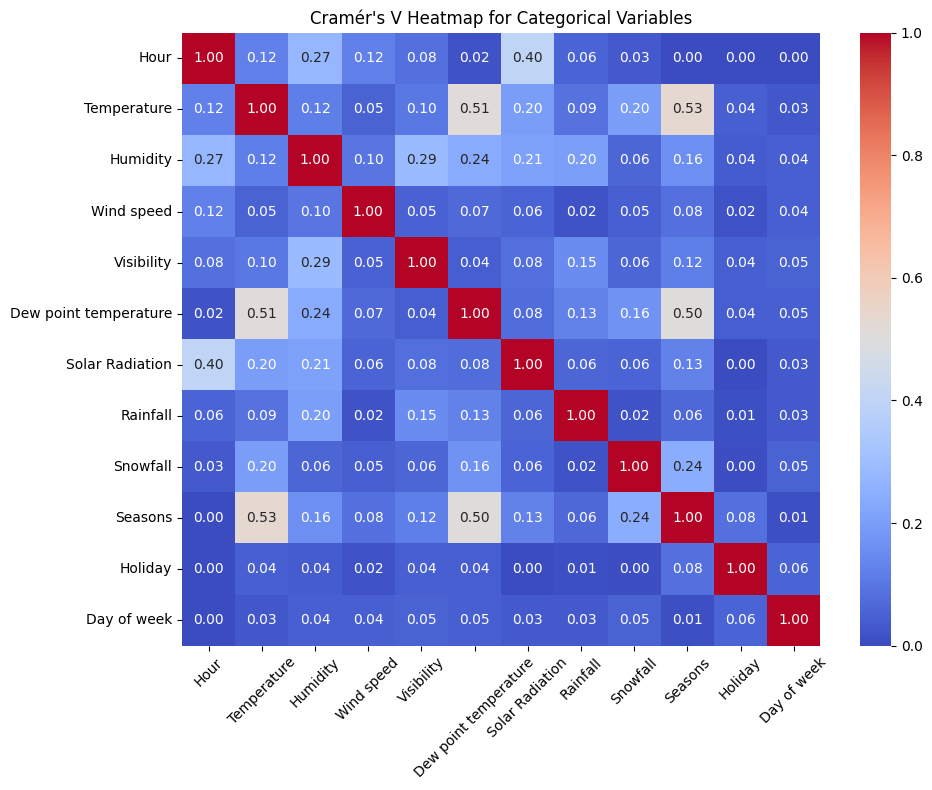

In [32]:
# Convert the Cramér's V matrix to a float type for proper heatmap visualization
cramers_v_matrix = cramers_v_matrix.astype(float)

plt.figure(figsize=(10, 8))
sns.heatmap(cramers_v_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, 
            vmin=0, vmax=1)

plt.title("Cramér's V Heatmap for Categorical Variables")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


We see that our assumptions were mostly correct as 'Temperature', 'Dew point temperature' and 'Seasons' are strongly associated (while 'Solar Radiation' values are surprisingly low in relation to the mentioned attributes). Let's check if the values are statistically relevant.

In [33]:
# Create contingency tables for pairs of variables
contingency_temp_dewpoint = pd.crosstab(df['Temperature'], df['Dew point temperature'])
contingency_temp_seasons = pd.crosstab(df['Temperature'], df['Seasons'])
contingency_dewpoint_seasons = pd.crosstab(df['Dew point temperature'], df['Seasons'])

# Perform Chi-Squared test for each pair
chi2_temp_dewpoint, p_temp_dewpoint, dof_temp_dewpoint, expected_temp_dewpoint = chi2_contingency(contingency_temp_dewpoint)
chi2_temp_seasons, p_temp_seasons, dof_temp_seasons, expected_temp_seasons = chi2_contingency(contingency_temp_seasons)
chi2_dewpoint_seasons, p_dewpoint_seasons, dof_dewpoint_seasons, expected_dewpoint_seasons = chi2_contingency(contingency_dewpoint_seasons)

# Print the p-values and chi-squared statistics
print(f"Chi-Squared Test for 'Temperature' vs 'Dew point temperature':")
print(f"Chi2 Statistic: {chi2_temp_dewpoint}, P-value: {p_temp_dewpoint}\n")

print(f"Chi-Squared Test for 'Temperature' vs 'Seasons':")
print(f"Chi2 Statistic: {chi2_temp_seasons}, P-value: {p_temp_seasons}\n")

print(f"Chi-Squared Test for 'Dew point temperature' vs 'Seasons':")
print(f"Chi2 Statistic: {chi2_dewpoint_seasons}, P-value: {p_dewpoint_seasons}\n")

Chi-Squared Test for 'Temperature' vs 'Dew point temperature':
Chi2 Statistic: 6933.856975614623, P-value: 0.0

Chi-Squared Test for 'Temperature' vs 'Seasons':
Chi2 Statistic: 7429.378933819105, P-value: 0.0

Chi-Squared Test for 'Dew point temperature' vs 'Seasons':
Chi2 Statistic: 6673.98966751281, P-value: 0.0



Considering the very large Chi-Squared statistics and p-values being effectively equal to 0 we can conclude that strong, non-random associations between the attributes in question exist. As a consequence we'll keep only one of them in our dataset. We decide 'Temperature' is the most appropriate one to keep, since it is easier to interpret than 'Dew point temperature', while also being less general than 'Seasons'.

In [34]:
df.drop(['Dew point temperature', 'Seasons'], axis=1, inplace=True)

Let's proceed with first round of WoE and IV calculations.

In [35]:
# Function to calculate WoE and IV for a categorical column
def calculate_woe_iv(df, column, target_column='Target', epsilon=1e-6):
    # Group by the categorical column and calculate the counts for 'Good' (high rentals count) and 'Bad' (low rentals count)
    grouped = df.groupby(column, observed=False)[target_column].agg(['count', lambda x: (x == 'high').sum(), lambda x: (x == 'low').sum()])
    
    # Rename the columns for clarity
    grouped.columns = ['Total', 'Good', 'Bad']
    
    # Calculate the Good and Bad Distribution
    total_good = grouped['Good'].sum()
    total_bad = grouped['Bad'].sum()
    
    # Add a small constant (epsilon) to avoid zero division
    grouped['Good Distribution'] = (grouped['Good'] + epsilon) / (total_good + epsilon)
    grouped['Bad Distribution'] = (grouped['Bad'] + epsilon) / (total_bad + epsilon)
    
    # Calculate WoE
    grouped['WoE'] = np.log(grouped['Good Distribution'] / grouped['Bad Distribution'])
    
    # Calculate IV
    grouped['IV'] = (grouped['Good Distribution'] - grouped['Bad Distribution']) * grouped['WoE']
    
    # Calculate total IV
    IV = grouped['IV'].sum()
    
    return grouped[['Good Distribution', 'Bad Distribution', 'WoE', 'IV']], IV

# Ensure the 'Target' column is defined
df['Target'] = np.where(df['Rented Bike Count'] == 'high', 'high', 'low')  # 'high' as Good, 'low' as Bad

# List of columns to calculate WoE and IV for, excluding 'Date' and 'Rented Bike Count'
categorical_columns = [
    'Hour', 'Temperature', 'Humidity', 'Wind speed', 'Visibility', 'Solar Radiation', 'Rainfall', 
    'Snowfall', 'Holiday', 'Day of week'
]

# Dictionary to hold the IV for each column
iv_dict = {}

# Iterate through the categorical columns and calculate WoE and IV
for column in categorical_columns:
    print(f'Calculating WoE and IV for {column}...')
    woe_iv_table, iv = calculate_woe_iv(df, column)
    iv_dict[column] = iv
    print(woe_iv_table)
    print(f'Total IV for {column}: {iv}\n')

Calculating WoE and IV for Hour...
      Good Distribution  Bad Distribution       WoE            IV
Hour                                                             
0              0.025162          0.049348 -0.673564  1.629072e-02
1              0.007908          0.057377 -1.981772  9.803642e-02
2              0.002516          0.059886 -3.169707  1.818463e-01
3              0.002157          0.060054 -3.326647  1.926022e-01
4              0.002157          0.060054 -3.326647  1.926022e-01
5              0.002157          0.060054 -3.326647  1.926022e-01
6              0.002157          0.060054 -3.326647  1.926022e-01
7              0.041337          0.041820 -0.011613  5.607120e-06
8              0.057513          0.034292  0.517080  1.200668e-02
9              0.041697          0.041653  0.001053  4.623290e-08
10             0.012940          0.055035 -1.447623  6.093739e-02
11             0.031632          0.046337 -0.381765  5.613716e-03
12             0.048886          0.038307

WoE tells us what is the strength and direction of relationship between an independent variable and the target attribute. IV summarizes how *predictive* this relationship is. We can group classes that have similar WoE values together since the latter means they express a similar relationship. In inspecting the results above we get a candidate for this early on since it appears sensible to group 'Hours' into different times of day.

The other candidates for similar grouping are:

- 'Humidity': we join 'low' and 'moderate' into 'low'.

- 'Visibility': we join 'low' and 'moderate' into 'low'.

- 'Rainfall': we join 'light' and 'moderate' into 'light'.

Let's perform the mergings.

In [36]:
# Classify 'Hour' into times of day
def classify_time_of_day(hour):
    if 0 <= hour <= 5:
        return 'night'
    elif 6 <= hour <= 11:
        return 'morning'
    elif 12 <= hour <= 17:
        return 'afternoon'
    elif 18 <= hour <= 23:
        return 'evening'

df['Time of Day'] = df['Hour'].apply(classify_time_of_day)

# Humidity: Join 'low' and 'moderate' into 'low'
def classify_humidity(humidity):
    if humidity in ['low', 'moderate']:
        return 'low'
    else:
        return humidity

df['Humidity'] = df['Humidity'].apply(classify_humidity)

# Visibility: Join 'low' and 'moderate' into 'low'
def classify_visibility(visibility):
    if visibility in ['low', 'moderate']:
        return 'low'
    else:
        return visibility

df['Visibility'] = df['Visibility'].apply(classify_visibility)

# Rainfall: Join 'no', 'light', and 'moderate' into 'light'
def classify_rainfall(rainfall):
    if rainfall in ['light', 'moderate']:
        return 'light'
    else:
        return rainfall

df['Rainfall'] = df['Rainfall'].apply(classify_rainfall)

We recalculate WoE and IV scores for the newly classified attributes.

In [37]:
print('Calculating WoE and IV for Time of Day...')
woe_iv_time_of_day, iv = calculate_woe_iv(df, 'Time of Day')
print(woe_iv_time_of_day)
print(f'Total IV for Time of Day: {iv}')

print('\nCalculating WoE and IV for Humidity...')
woe_iv_humidity, iv_humidity = calculate_woe_iv(df, 'Humidity')
print(woe_iv_humidity)
print(f'Total IV for Humidity: {iv_humidity}\n')

print('\nCalculating WoE and IV for Visibility...')
woe_iv_visibility, iv_visibility = calculate_woe_iv(df, 'Visibility')
print(woe_iv_visibility)
print(f'Total IV for Visibility: {iv_visibility}\n')

print('\nCalculating WoE and IV for Rainfall...')
woe_iv_rainfall, iv_rainfall = calculate_woe_iv(df, 'Rainfall')
print(woe_iv_rainfall)
print(f'Total IV for Rainfall: {iv_rainfall}\n')

Calculating WoE and IV for Time of Day...
             Good Distribution  Bad Distribution       WoE        IV
Time of Day                                                         
afternoon             0.355859          0.200736  0.572544  0.088815
evening               0.414809          0.173302  0.872783  0.210784
morning               0.187275          0.279190 -0.399314  0.036703
night                 0.042056          0.346771 -2.109662  0.642847
Total IV for Time of Day: 0.979147877928364

Calculating WoE and IV for Humidity...
          Good Distribution  Bad Distribution       WoE        IV
Humidity                                                         
high               0.192308          0.368518 -0.650393  0.114606
low                0.807692          0.631482  0.246112  0.043367
Total IV for Humidity: 0.1579731918474015


Calculating WoE and IV for Visibility...
            Good Distribution  Bad Distribution       WoE        IV
Visibility                                 

In [38]:
# Updated columns list
categorical_columns = [
    'Time of Day', 'Temperature', 'Humidity', 'Wind speed', 'Visibility', 'Solar Radiation', 
    'Rainfall', 'Snowfall', 'Holiday', 'Day of week'
]

iv_dict = {}

# Again iterate through the categorical columns and calculate WoE and IV
for column in categorical_columns:
    woe_iv_table, iv = calculate_woe_iv(df, column)
    iv_dict[column] = iv

# IV of all columns in a summary, sorted by IV value
iv_summary = pd.DataFrame(list(iv_dict.items()), columns=['Column', 'IV'])

# Sort by the 'IV' column in descending order
iv_summary = iv_summary.sort_values(by='IV', ascending=False)

print('Sorted IV totals:')
print(iv_summary)

Sorted IV totals:
            Column        IV
1      Temperature  1.480233
0      Time of Day  0.979148
7         Snowfall  0.397532
6         Rainfall  0.291921
2         Humidity  0.157973
5  Solar Radiation  0.155932
4       Visibility  0.110150
8          Holiday  0.014151
9      Day of week  0.013019
3       Wind speed  0.005207


Checking IV totals we see that 'Time of Day' achieves a lower overall IV score (cca. 0.979) then 'Hour' did in the results before (cca. 1.505). This can be explained by the fact that by merging the original feature into a broader time category we lost some granularity and distinctive patterns that the individual hours offered. However, the individual class IV values are generally a lot better for 'Time of Day' and will also make our Bayesian model simpler to interpret. As for IV totals of other additionaly modified attributes we find they remain about the same.

Based on the final results we decide to ditch last three of the attributes listed (an attribute with IV score lower than 0.02 is generally considered not to be useful) and keep the rest.

In [ ]:
# Drop the specified columns from the DataFrame (including 'Date' and 'Target' "helper" columns)
df = df.drop(columns=['Date', 'Holiday', 'Hour', 'Day of week', 'Wind speed', 'Target'])
# Save dataframe to csv for doing further work using GeNIe
df.to_csv("./artifacts/final_bikes.csv", index=False)
df.head()

,Rented Bike Count,Temperature,Humidity,Visibility,Solar Radiation,Rainfall,Snowfall,Time of Day
0,low,cold,low,high,low,no,no,night
1,low,cold,low,high,low,no,no,night
2,low,cold,low,high,low,no,no,night
3,low,cold,low,high,low,no,no,night
4,low,cold,low,high,low,no,no,night


Here we can see the final structure of our dataset. We could use it to build a Bayesian network via a tool like GeNIe (https://download.bayesfusion.com/files.html?category=Academia).